In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [93]:
test_img_path = '/content/drive/MyDrive/BE Project : AyuFlora /Dataset/ColabFigures/Jth_1.jpg'

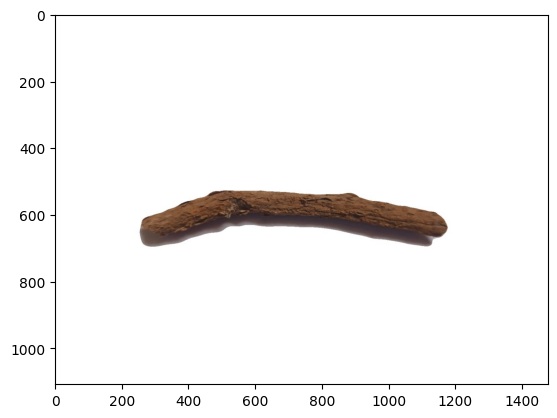

In [94]:
main_img = cv2.imread(test_img_path)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

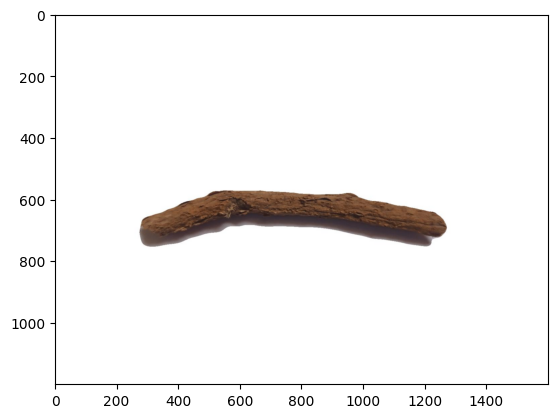

In [95]:
resized_image = cv2.resize(img, (1600, 1200))
plt.imshow(resized_image,cmap="Greys_r")

In [96]:
y,x,_ = img.shape

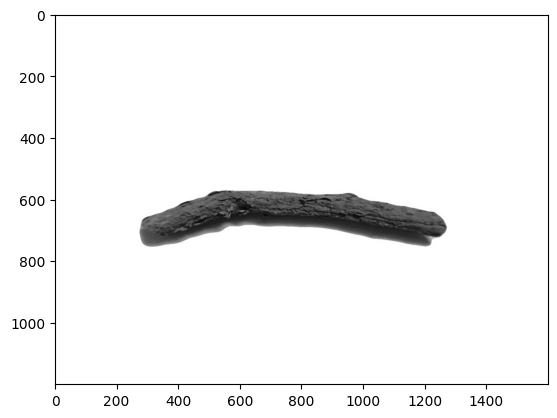

In [97]:
gs = cv2.cvtColor(resized_image,cv2.COLOR_RGB2GRAY)
plt.imshow(gs,cmap="Greys_r")

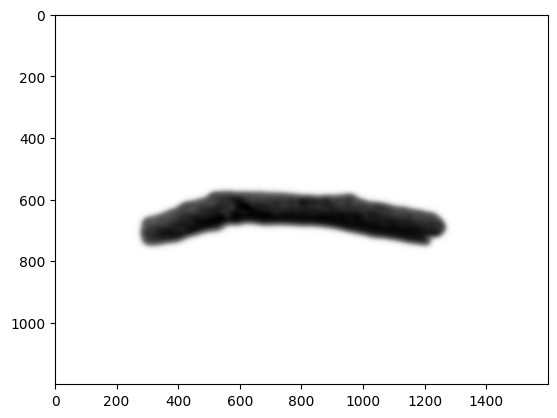

In [98]:
blur = cv2.GaussianBlur(gs, (55,55),0)
plt.imshow(blur,cmap="Greys_r")

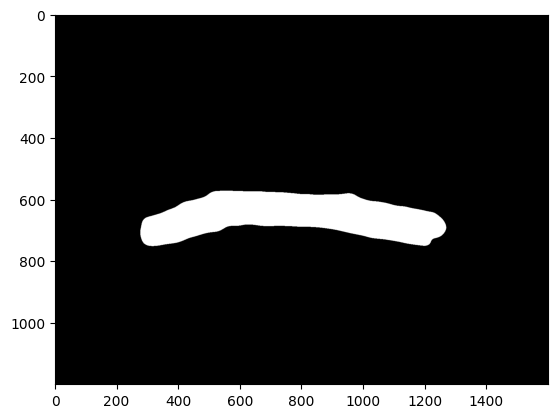

In [99]:
ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu,cmap='Greys_r')

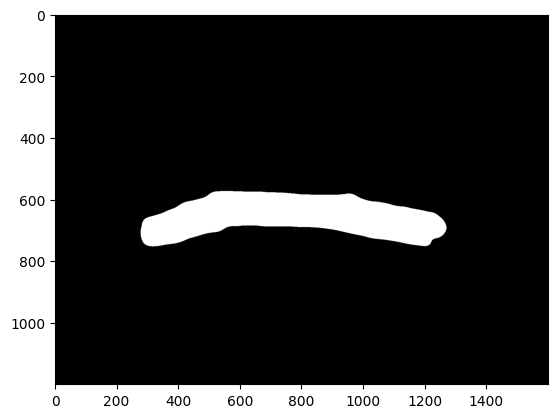

In [100]:
kernel = np.ones((50,50),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing,cmap="Greys_r")

In [101]:
contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [102]:
len(contours)

1

# ***Boundary extraction***

***Boundary extraction is needed which will be used in calculation of shape features. Boundary extraction using sobel filters - Not effective
Trying to extract the boundary of the leaf using sobel filters. The image after edge extraction is thresholded using Otsu's method. Then the gaps were closed using Closing operation of Morphological Transformation. This method is not effective as even after performing morphological transformation, gaps still persist.***


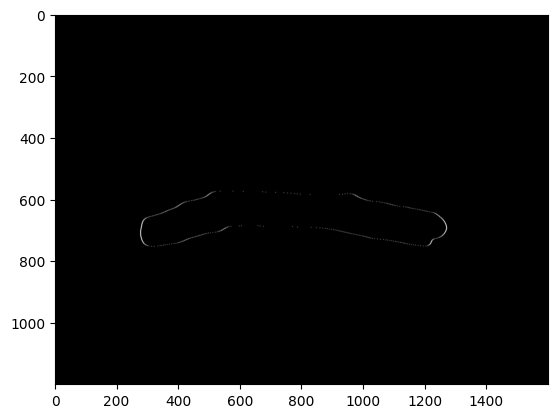

In [103]:
sobelx64f = cv2.Sobel(closing,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.imshow(abs_sobel64f,cmap='Greys_r')

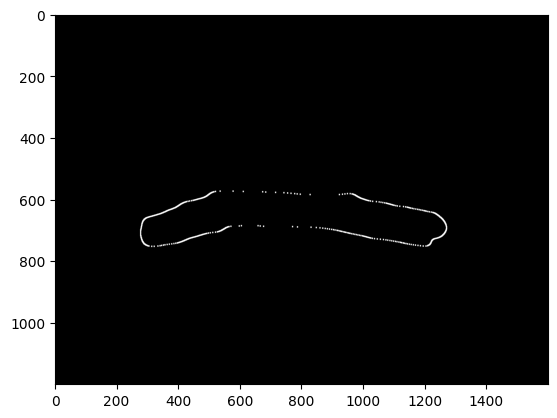

In [104]:
ret_sobel,im_bw_sobel = cv2.threshold(sobel_8u,1,255,cv2.THRESH_BINARY)
plt.imshow(im_bw_sobel,cmap='Greys_r')

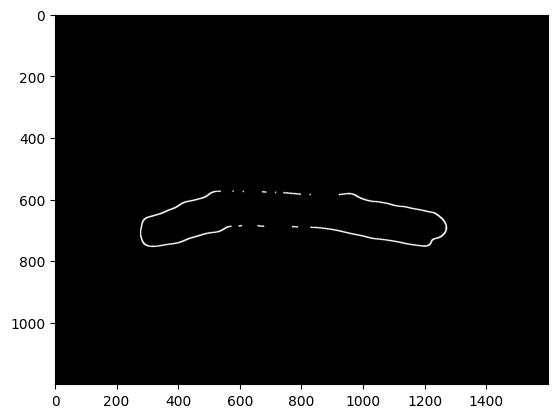

In [105]:
kernel_edge = np.ones((15,15),np.uint8)
closing_edge = cv2.morphologyEx(im_bw_sobel, cv2.MORPH_CLOSE, kernel_edge)
plt.imshow(closing_edge,cmap='Greys_r')


# ***Boundary extraction using contours - Effective***

***Contours are used to extract leaf boundaries. They are continous, sharp and there are no gaps between the boundary pixels***


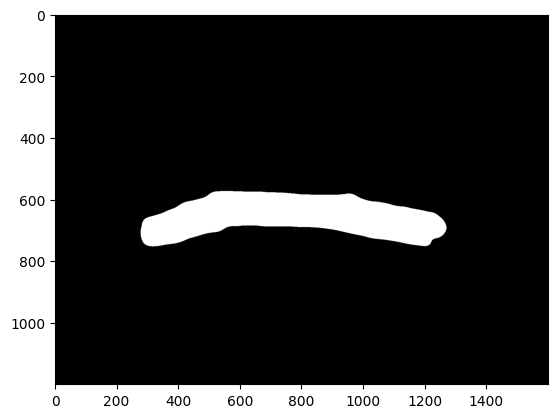

In [106]:
plt.imshow(closing,cmap="Greys_r")

In [107]:
contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [108]:
len(contours)

1

In [109]:
def find_contour(cnts):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    print(contains)
    return val[0]

In [110]:
index = find_contour(contours)
cnt = contours[index]
len(cnt)

[1.0]


706

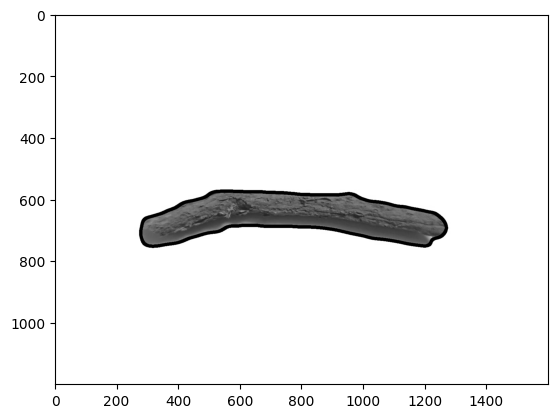

In [111]:
plottedContour = cv2.drawContours(gs,contours,-1,(0,255,0),10)
plt.imshow(plottedContour,cmap="Greys_r")

# ***Morphological processing***
***1. Shape based features: Calculating moments using contours***

In [112]:
M = cv2.moments(cnt)
M

{'m00': 109557.0,
 'm10': 84409066.5,
 'm01': 72124629.5,
 'm20': 73496818613.0,
 'm11': 55655802580.0,
 'm02': 47661530733.666664,
 'm30': 69662043787325.45,
 'm21': 48687919349683.37,
 'm12': 36832128368878.56,
 'm03': 31613963946394.35,
 'mu20': 8463178522.4405365,
 'mu11': 86805183.6368103,
 'mu02': 179743348.9055786,
 'mu30': -5214783530.5,
 'mu21': 169019590401.74023,
 'mu12': -3371878543.6178284,
 'mu03': 300826206.875,
 'nu20': 0.7051040985046756,
 'nu11': 0.007232116230500559,
 'nu02': 0.014975197752975187,
 'nu30': -0.0013126107496936464,
 'nu21': 0.042543842898282176,
 'nu12': -0.0008487339881181514,
 'nu03': 7.572082534667154e-05}

In [113]:
area = cv2.contourArea(cnt)
area

109557.0

In [114]:
perimeter = cv2.arcLength(cnt,True)
perimeter

2242.655977010727


***Fitting in the best-fit rectangle and ellipse***

***The best-fit rectangle is chosen and not ellipse as removes some portion at the extreme ends.***


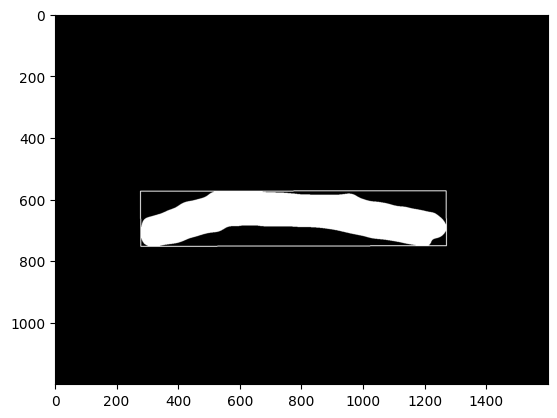

In [115]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.intp(box) #np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),2)
plt.imshow(contours_im,cmap="Greys_r")

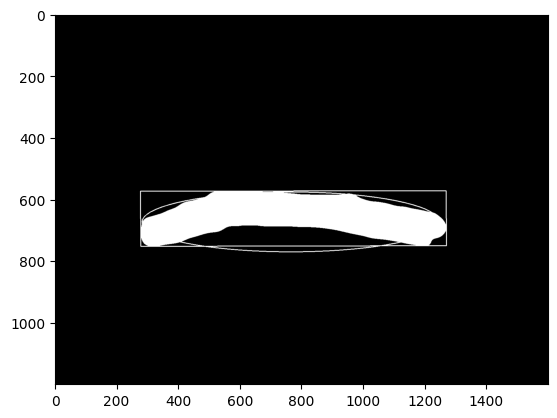

In [116]:
ellipse = cv2.fitEllipse(cnt)
im = cv2.ellipse(closing,ellipse,(255,255,255),2)
plt.imshow(closing,cmap="Greys_r")

***Shape based features calculated - Aspect ratio, rectangularity, circularity etc.***

In [117]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

5.516666666666667

In [118]:
rectangularity = w*h/area
rectangularity

1.6314795038199295

In [119]:
circularity = ((perimeter)**2)/area
circularity

45.90766296285895

In [120]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

np.float64(373.48668624537373)

In [121]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)

# ***2. Color based features***

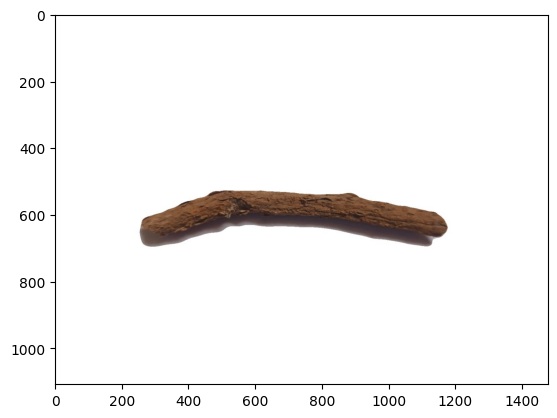

In [122]:
plt.imshow(img,cmap="Greys_r")

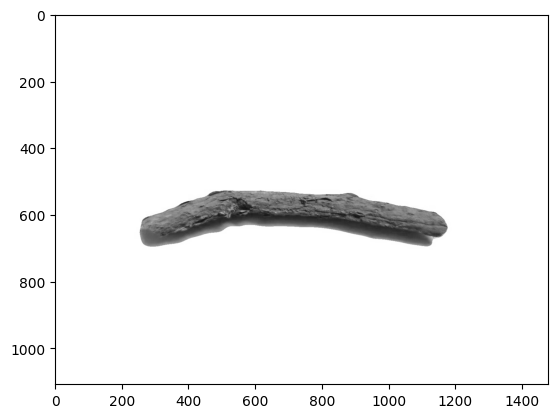

In [134]:
red_channel = img[:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

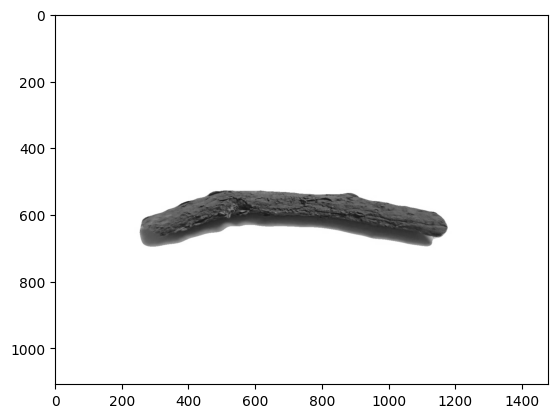

In [135]:
green_channel = img[:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

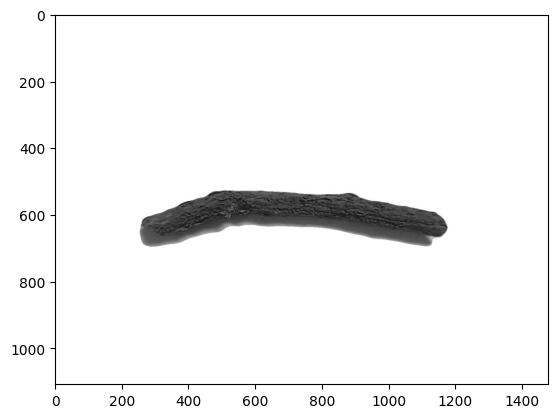

In [136]:
blue_channel = img[:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [137]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [138]:
red_mean = np.mean(red_channel)
red_mean

np.float64(6.911625012823456)

In [139]:
green_mean = np.mean(green_channel)
green_mean

np.float64(5.402378079461464)

In [140]:
blue_mean = np.mean(blue_channel)
blue_mean

np.float64(4.547390609810311)

In [141]:
red_var = np.std(red_channel)
red_var

np.float64(29.098943524949792)

# ***3. Texture based features***
***Using Haralick moments - calculating texture based features such as contrast, correlation, entropy***

In [143]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.1 MB/s eta 0:00:00


In [144]:
import mahotas as mt

In [145]:
textures = mt.features.haralick(gs)
ht_mean = textures.mean(axis=0)
ht_mean

array([ 8.71977438e-01,  1.55158711e+01,  9.95621753e-01,  1.77169864e+03,
        9.52096066e-01,  4.89083201e+02,  7.07127867e+03,  8.59083539e-01,
        1.09142080e+00,  3.45789238e-03,  5.48160385e-01, -5.98007888e-01,
        7.77799365e-01])

In [146]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[4]) #inverse difference moments
print(ht_mean[8]) #entropy

15.515871079851784
0.9956217528472443
0.9520960658824069
1.0914208041935758
